# Сравнение результатов работы KNN, DT и RF на MNIST'е

In [137]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
digits = load_digits() # загрузка датасета 

In [4]:
X = digits.data
y = digits.target
images = digits.images

In [22]:
def show_random_images(data, size = 5):  #функция отрисовки изображений
    """
    Функция для отрисовки size x size случайных изображений из data.
    """
    
    plt.figure(figsize=(12 ,5))
    for i in range(size):
        for j in range(size):
            
            num = i * size + j
            plt.subplot(size, size, num + 1)
            pic = np.resize(data[num], (8, 8))
            plt.imshow(pic, cmap='gray')
            plt.axis('off')
    
    plt.show()

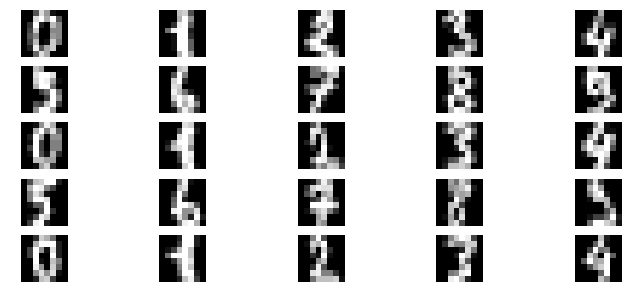

In [23]:
show_random_images(images)

### Разделим выборку на тест и трейн. На тесте оставим 30% данных

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### KNN

 Сначала посмотрим на качество с дефолтными параметрами

In [72]:
knn_class = KNeighborsClassifier()
knn_class.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [73]:
print(accuracy_score(y_test, knn_class.predict(X_test)))

0.977777777778


Очень неплохой результат, но попробуем улучшить.  
Подберем сначала метрику, а затем найдем оптимальное количество соседей.

In [98]:
metric_candidates = range(1,10)
param = {'p' : metric_candidates,             
}

In [89]:
gs = GridSearchCV(knn_class, param, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'p': range(1, 10)}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score=True, scoring=None, verbose=1)

In [95]:
gs.best_params_, gs.best_score_

({'p': 8}, 0.98647573587907722)

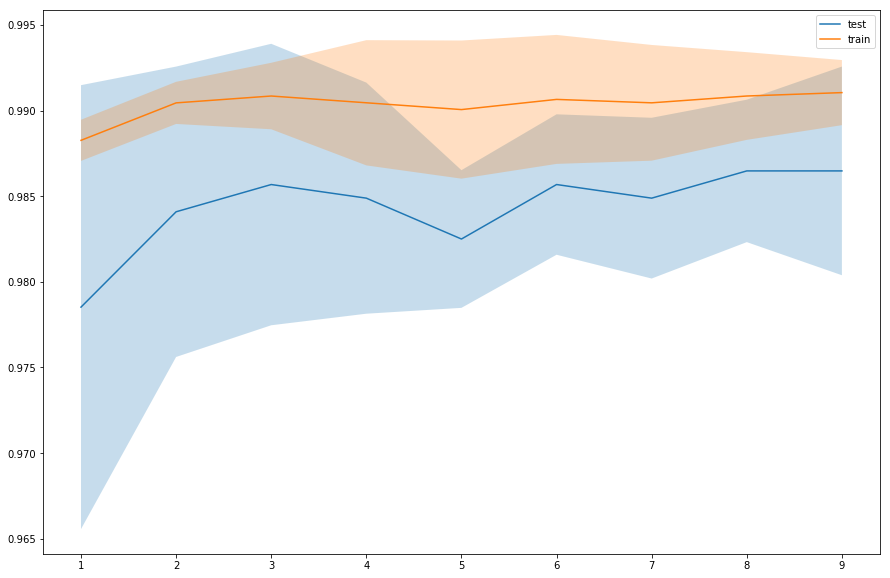

In [118]:
cv_mean = gs.cv_results_['mean_test_score']
cv_std = gs.cv_results_['std_test_score']
cv_mean_train = gs.cv_results_['mean_train_score']
cv_std_train = gs.cv_results_['std_train_score']
plt.plot(metric_candidates, cv_mean, label='test')
plt.fill_between(metric_candidates, cv_mean - cv_std, cv_mean + cv_std, alpha=0.25)
plt.plot(metric_candidates, cv_mean_train, label='train')
plt.fill_between(metric_candidates, cv_mean_train - cv_std_train, cv_mean_train + cv_std_train, alpha=0.25)
plt.legend()
plt.show()

In [127]:
knn_class = KNeighborsClassifier(p=8)
n_neighbors_candidate = range(1, 30)
param = {'n_neighbors' : n_neighbors_candidate,   
}
gs = GridSearchCV(knn_class, param, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  9.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=8,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 30)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=1)

In [128]:
gs.best_params_, gs.best_score_

({'n_neighbors': 5}, 0.98647573587907722)

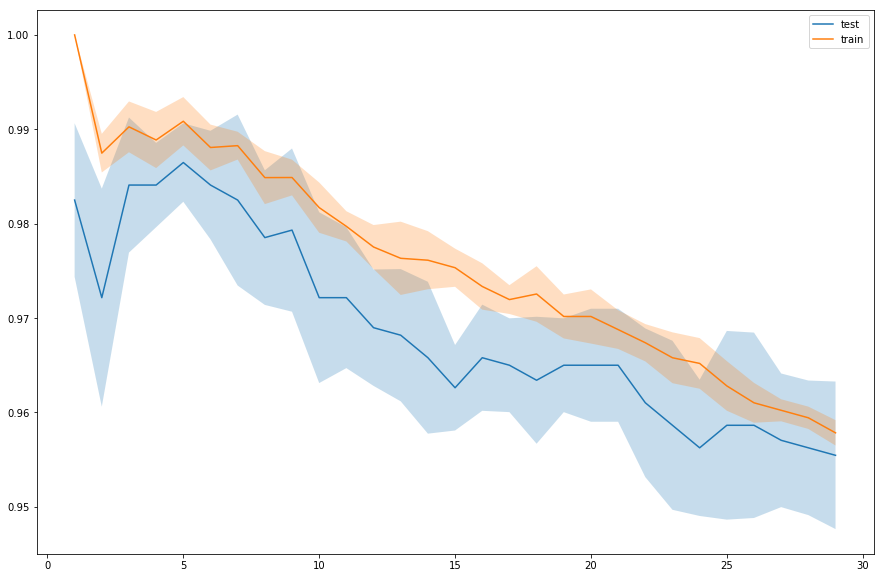

In [129]:
cv_mean = gs.cv_results_['mean_test_score']
cv_std = gs.cv_results_['std_test_score']
cv_mean_train = gs.cv_results_['mean_train_score']
cv_std_train = gs.cv_results_['std_train_score']
plt.plot(n_neighbors_candidate, cv_mean, label='test')
plt.fill_between(n_neighbors_candidate, cv_mean - cv_std, cv_mean + cv_std, alpha=0.25)
plt.plot(n_neighbors_candidate, cv_mean_train, label='train')
plt.fill_between(n_neighbors_candidate, cv_mean_train - cv_std_train, cv_mean_train + cv_std_train, alpha=0.25)
plt.legend()
plt.show()

лучшие параметры: p=8 и число соседей=5.   
__НО__ они подобраны отдельно. Почему не подбирал через сетку?  
Тогда бы пришлось бы считать 1500 раз  (кол-во_p x кол-во_соседей x кол-во_фолдов )  
А это примерно 200 минут

Посмотрим теперь на точность на тесте с подобранными параметрами.

In [136]:
knn_class_tuned = KNeighborsClassifier(n_neighbors=5, p=8, weights='distance', n_jobs=-1)
knn_class_tuned.fit(X_train, y_train)
print(accuracy_score(y_test, knn_class_tuned.predict(X_test)))

0.972222222222


О боже, это даже ухудшило

## DT

Принцип тот же. Посмотрим на не настроенный, потом подберем параметры.

In [138]:
tr = DecisionTreeClassifier()
tr.fit(X_train, y_train)
print(accuracy_score(y_test, tr.predict(X_test)))

0.825925925926


Очень плохой результат для дерева. Попробуем хотя бы тут поднять скор. Тут будем подбирать сразу по всем. Кросс-валидацию будем проводить по 3 фолдам.

In [140]:
tree_param = {'max_depth' : range(5, 100, 5), 
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf' : range(1, 10) 
}

In [143]:
gs_tree = GridSearchCV(tr, tree_param, cv=3, verbose=1)
gs_tree.fit(X_train, y_train)

Fitting 3 folds for each of 684 candidates, totalling 2052 fits


[Parallel(n_jobs=1)]: Done 2052 out of 2052 | elapsed:   32.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 100, 5), 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [145]:
gs_tree.best_params_, gs_tree.best_score_

({'max_depth': 15, 'max_features': None, 'min_samples_leaf': 3},
 0.84486873508353222)

In [146]:
tr_tuned = DecisionTreeClassifier(max_depth=15, max_features=None, min_samples_leaf=3)
tr_tuned.fit(X_train, y_train)
print(accuracy_score(y_test, tr_tuned.predict(X_test)))

0.837037037037


Нам удалось улучшить точность дерева на 1%